In [4]:
import os
import csv
import matplotlib.pyplot as plt
import subprocess
import time
import numpy as np

In [2]:
# File and Directory Paths
source_dir = "source_files/"
source_metadata_file = source_dir + "papers.csv"
processed_metadata_file = source_dir + "papers_processed.csv"

table_output_dir = "extracted_tables/"
table_code_dir = table_output_dir + "table_code/"
table_images_dir = table_output_dir + "table_images/"
table_metadata_file = table_output_dir + "tables.csv"

figure_output_dir = "extracted_figures/"
figure_metadata_file = figure_output_dir + "figures.csv"

# CSV Size Limit
csv.field_size_limit(260000)

131072

In [73]:
def check_row_length(file_path, row_length):
    corrupted_objects = []
    with open(file_path, "r", encoding="utf-8") as metadata:
        spamreader = csv.reader(metadata, delimiter=';', quotechar='|', quoting=csv.QUOTE_ALL)
        for row in spamreader:
            if len(row) != row_length:
                corrupted_objects.append(row)
                print(f"Unexpected row length of {len(row)} for: {row[0]}")
    print(f"Check for {file_path} complete. {len(corrupted_objects)} rows were corrupted.")
    return corrupted_objects

# Check paper metadata files for errors
original_corrupted_papers = check_row_length(source_metadata_file, 3)
processed_corrupted_papers = check_row_length(processed_metadata_file, 5)

Check for source_files/papers.csv complete. 0 rows were corrupted.
Check for source_files/papers_processed.csv complete. 0 rows were corrupted.


In [25]:
# Repairing paper titels including a semicolumn
repaired_papers = {}
for paper_row in original_corrupted_papers:
    if len(paper_row) == 4:
        new_row = [paper_row[0], paper_row[1] + "," + paper_row[2], paper_row[3]]
        repaired_papers[paper_row[0]] = new_row
    else:
        raise ValueError(f"Unexpected row length for {paper_row}.")

print(f"{len(repaired_papers)} rows were fixed.")

42 rows were fixed.


In [26]:
# Fix for original source paper file
with open(source_metadata_file, "r", newline='', encoding='utf-8') as input_file:
        with open(source_dir + "tmp.csv", "w", newline='', encoding='utf-8') as output_file:
            csv_reader = csv.reader(input_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csv_writer = csv.writer(output_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            
            for row in csv_reader:
                if row[0] in repaired_papers:
                    csv_writer.writerow(repaired_papers[row[0]])
                else:
                    csv_writer.writerow(row)
                    
# Replace old csv file with new csv file
os.replace(source_dir + "tmp.csv", source_metadata_file)
print("Original papers csv file was successfully overwritten.")

# Fix for processed paper file
with open(processed_metadata_file, "r", newline='', encoding='utf-8') as input_file:
        with open(source_dir + "tmp.csv", "w", newline='', encoding='utf-8') as output_file:
            csv_reader = csv.reader(input_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csv_writer = csv.writer(output_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            
            for row in csv_reader:
                if row[0] in repaired_papers:
                    if len(row) > paper_processed_row_length:
                        new_row = repaired_papers[row[0]] + [row[-2], row[-1]]
                        csv_writer.writerow(new_row)
                    else:
                        print(f"Critical error for {row}. Please fix it manually.")
                        csv_writer.writerow(row)
                else:
                    csv_writer.writerow(row)
                    
# Replace old csv file with new csv file
os.replace(source_dir + "tmp.csv", processed_metadata_file)

print("Processed papers csv file was successfully overwritten.")

Original papers csv file was successfully overwritten.
Processed papers csv file was successfully overwritten.


In [45]:
# Checking if unprocessed ppaers are still on the disk
for paper_row in processed_corrupted_papers:
    if len(paper_row) != 3:
        print(paper_row)
    else:
        paper_id = paper_row[0]
        if not os.path.isdir(source_dir+paper_id):
            raise ValueError(f"No files found for paper {paper_id}")
            
paper_ids = [row[0] for row in processed_corrupted_papers]
critical_figs = []
critical_tabs = []

# Remove critical figures to allow for reprocessing
with open(figure_metadata_file, "r", newline='', encoding='utf-8') as input_file:
        with open(figure_output_dir + "tmp.csv", "w", newline='', encoding='utf-8') as output_file:
            csv_reader = csv.reader(input_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csv_writer = csv.writer(output_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            
            for row in csv_reader:
                if row[1] not in paper_ids:
                    csv_writer.writerow(row)
                else:
                    critical_figs.append(row[0])
os.replace(figure_output_dir + "tmp.csv", figure_metadata_file)

# Remove critical figures to allow for reprocessing
with open(table_metadata_file, "r", newline='', encoding='utf-8') as input_file:
        with open(table_output_dir + "tmp.csv", "w", newline='', encoding='utf-8') as output_file:
            csv_reader = csv.reader(input_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csv_writer = csv.writer(output_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            
            for row in csv_reader:
                if row[1] not in paper_ids:
                    csv_writer.writerow(row)
                else:
                    critical_tabs.append(row[0])
os.replace(table_output_dir + "tmp.csv", table_metadata_file)

print(f"{len(critical_figs)} figures and {len(critical_tabs)} have been removed.")

5 figures and 6 were removed.


In [49]:
# Removing these unprocessed papers from csv file
with open(processed_metadata_file, "r", newline='', encoding='utf-8') as input_file:
        with open(source_dir + "tmp.csv", "w", newline='', encoding='utf-8') as output_file:
            csv_reader = csv.reader(input_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csv_writer = csv.writer(output_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            
            for row in csv_reader:
                if row[0] not in paper_ids:
                    csv_writer.writerow(row)
                    
# Replace old csv file with new csv file
os.replace(source_dir + "tmp.csv", processed_metadata_file)

print("Processed papers csv file was successfully overwritten.")

Processed papers csv file was successfully overwritten.


In [7]:
# Checking metadata files for double occurrences
def check_for_double(file_path):
    with open(file_path, "r", newline='', encoding='utf-8') as csv_file:
        spamreader = csv.reader(csv_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        id_set = set()
        for row in spamreader:
            if row[0] in id_set:
                print(f"Double finding of {row[0]}")
            id_set.add(row[0])
    print(f"Check for {file_path} completed.")
    
check_for_double(source_metadata_file)
check_for_double(processed_metadata_file)
check_for_double(figure_metadata_file)
check_for_double(table_metadata_file)

Check for source_files/papers.csv completed.
Check for source_files/papers_processed.csv completed.
Check for extracted_figures/figures.csv completed.
Check for extracted_tables/tables.csv completed.


In [74]:
# Table and Figure checks

table_rows = check_row_length(table_metadata_file, 5)
figure_rows = check_row_length(figure_metadata_file, 5)

print(len(table_rows), len(figure_rows))

Check for extracted_tables/tables.csv complete. 0 rows were corrupted.
Check for extracted_figures/figures.csv complete. 0 rows were corrupted.
0 0


In [69]:
for i in range(len(table_rows)):
    table_rows[i][4] = ";".join(table_rows[i][4:])
    table_rows[i] = table_rows[i][:5]
    
for i in range(len(figure_rows)):
    figure_rows[i][4] = ";".join(figure_rows[i][4:])
    figure_rows[i] = figure_rows[i][:5]


for row in table_rows:
    if len(row) != 5:
        print("Error!", row[0], len(row))
        
for row in figure_rows:
    if len(row) != 5:
        print("Error!", row[0], len(row))
        
print("Complete")

Complete


In [15]:
import regex as re

def refine_caption(file_path):
    caption_regex = r"\\caption\{(([^{}]*(\{[^{}]*\})?[^{}]*)+)\}"
    refined_captions = {}
    counter = 0
    with open(file_path, "r", newline='', encoding='utf-8') as csv_file:
        spamreader = csv.reader(csv_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        
        for row in spamreader:
            caption_match = re.search(caption_regex, row[3])
            if caption_match:
                refined_captions[row[0]] = caption_match.group(1)
            else:
                counter += 1
        
    print(f"{counter} errors found.")
    return refined_captions
                
table_captions = refine_caption(table_metadata_file)
figure_captions = refine_caption(figure_metadata_file)
print("Check complete.")

2800 errors found.
33511 errors found.
Check complete.


In [32]:
# Replacing semicolons in captions
for cap in figure_captions:
    if ";" in figure_captions[cap]:
        figure_captions[cap] = figure_captions[cap].replace(";", ",")
        
for cap in table_captions:
    if ";" in table_captions[cap]:
        table_captions[cap] = table_captions[cap].replace(";", ",")

0


In [43]:
# Remove objects with mismatched caption regex
def replace_objects(file_path, obj_dic, table=True):
    with open(file_path, "r", newline='', encoding='utf-8') as input_file:
        with open("tmp.csv", "w", newline='', encoding='utf-8') as output_file:
            csv_reader = csv.reader(input_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csv_writer = csv.writer(output_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            
            for row in csv_reader:
                if row[0] in obj_dic:
                    row[3] = obj_dic[row[0]]
                    csv_writer.writerow(row)
                else:
                    if table:
                        if os.path.isfile(table_code_dir + row[0] + ".tex"):
                            os.remove(table_code_dir + row[0] + ".tex")
                        if os.path.isfile(table_images_dir + row[0] + ".png"):
                            os.remove(table_images_dir + row[0] + ".png")
                    else:
                        for ext in [".png", ".jpg", ".jpeg"]:
                            if os.path.isfile(figure_output_dir + row[0] + ext):
                                os.remove(figure_output_dir + row[0] + ext)
                                break
                    
    # Replace old csv file with new csv file
    os.replace("tmp.csv", file_path)

    print("CSV file was successfully overwritten.")
    
replace_objects(table_metadata_file, table_captions)
replace_objects(figure_metadata_file, figure_captions, False)

CSV file was successfully overwritten.
0
CSV file was successfully overwritten.
0


In [111]:
def analyze_text_mentions(file_path):
    mention_lengths = np.array([])
    with open(file_path, "r", newline='', encoding='utf-8') as csv_file:
        spamreader = csv.reader(csv_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in spamreader:
            if len(row) == 5:
                mention_lengths = np.append(mention_lengths, len(row[-1].split()))
            else:
                raise ValueError(f"Unexpected row length for {row[0]}.")
    
    # Statistics
    print("Number of samples:", len(mention_lengths))
    print("Lowest value:", mention_lengths.min())
    print("Highest value:", mention_lengths.max())
    print("Average value:", np.average(mention_lengths))
    print("Median value:", np.median(mention_lengths))
    
    # Filtering large lengths
    filtered_mention_lengths_1000 = [x for x in mention_lengths if x <= 1000]
    filtered_mention_lengths_400 = [x for x in filtered_mention_lengths_1000 if x <= 400]
    print("Number of objects with a text mention word length above 1000:", len(mention_lengths)-len(filtered_mention_lengths_1000))
    print("Number of objects with a text mention word length above 400:", len(mention_lengths)-len(filtered_mention_lengths_400))
    
    # Plotting the figures
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
    axes[0].hist(filtered_mention_lengths_1000, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].set_title("Distribution of Text Mention Word Lengths (under 1000 words)", fontsize=10)
    axes[0].set_xlabel("Word Length", fontsize=12)
    axes[0].set_ylabel("Frequency", fontsize=12)
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    axes[1].hist(filtered_mention_lengths_400, bins=30, color='coral', edgecolor='black', alpha=0.7)
    axes[1].set_title("Distribution of Text Mention Word Lengths (under 400 words)", fontsize=10)
    axes[1].set_xlabel("Word Length", fontsize=12)
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Number of samples: 33993
Lowest value: 40.0
Highest value: 10660.0
Average value: 190.30041479128056
Median value: 133.0
Number of objects with a text mention word length above 1000: 296
Number of objects with a text mention word length above 400: 2817


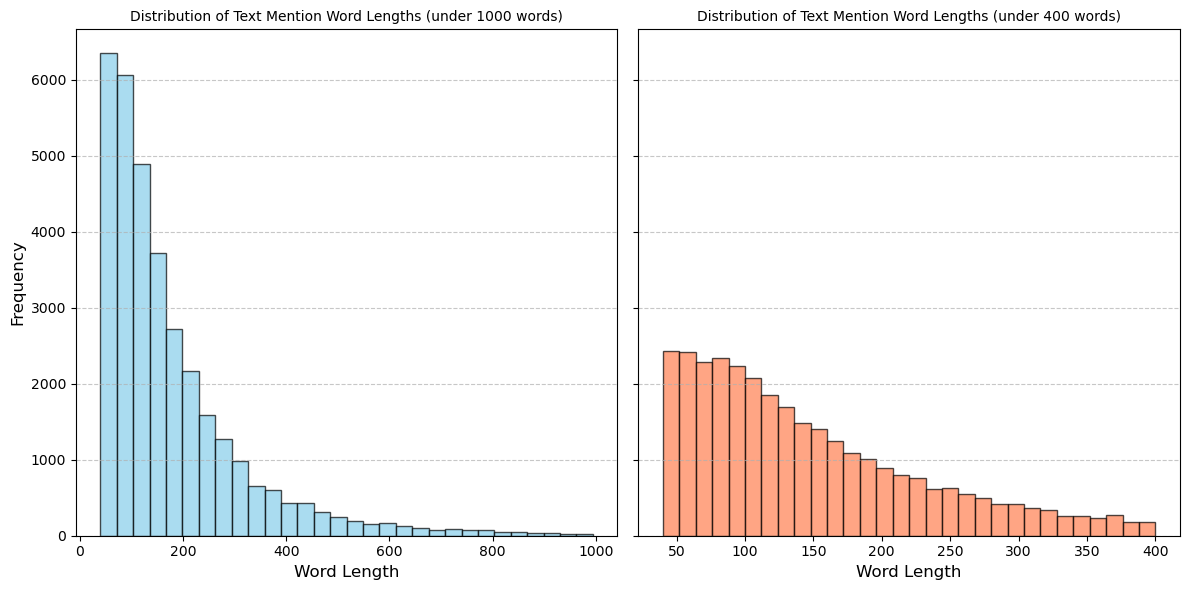

In [112]:
analyze_text_mentions(table_metadata_file)

Number of samples: 224497
Lowest value: 40.0
Highest value: 24090.0
Average value: 190.6322801641002
Median value: 135.0
Number of objects with a text mention word length above 1000: 1725
Number of objects with a text mention word length above 400: 19849


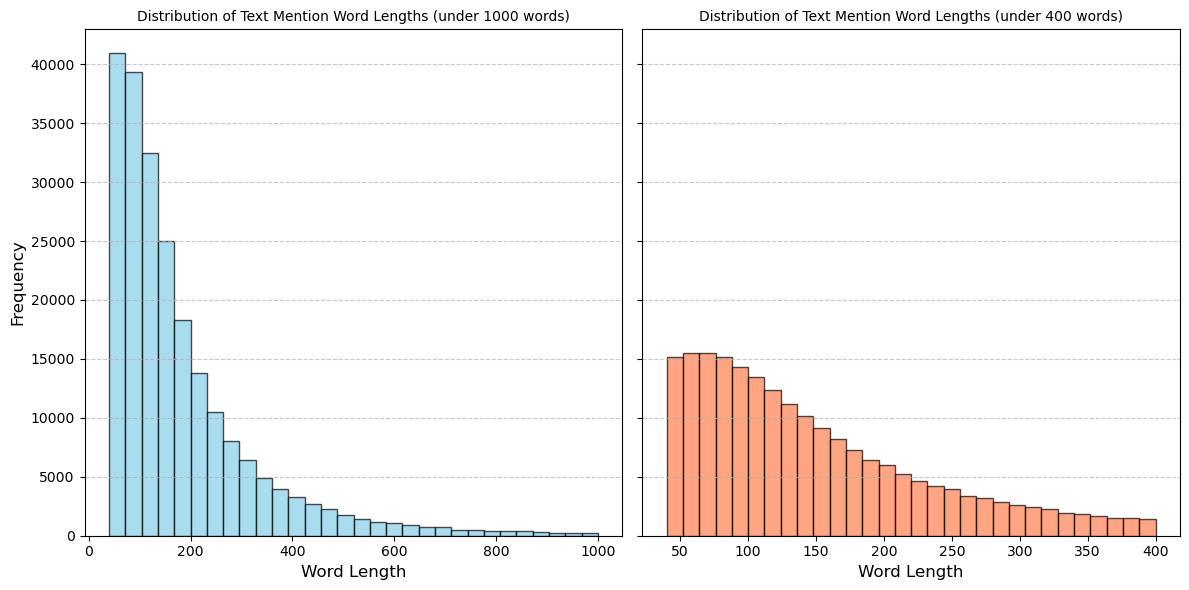

In [113]:
analyze_text_mentions(figure_metadata_file)

In [115]:
def check_word_length(file_path, threshold):
    corrupted_objects = []
    with open(file_path, "r", newline='', encoding='utf-8') as csv_file:
        spamreader = csv.reader(csv_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in spamreader:
            if len(row) == 5:
                if len(row[-1].split()) > threshold:
                    corrupted_objects.append(row[0])
            else:
                raise ValueError(f"Unexpected row length for {row[0]}.")
    return corrupted_objects

WORD_MAX_THRESHOLD = 300
corrupted_tables = check_word_length(table_metadata_file, WORD_MAX_THRESHOLD)
corrupted_figures = check_word_length(figure_metadata_file, WORD_MAX_THRESHOLD)

print(len(corrupted_tables), len(corrupted_figures))

5008 35049


In [117]:
def remove_objects(file_path, obj_list, table=True):
    with open(file_path, "r", newline='', encoding='utf-8') as input_file:
        with open("tmp.csv", "w", newline='', encoding='utf-8') as output_file:
            csv_reader = csv.reader(input_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            csv_writer = csv.writer(output_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            
            counter = 0
            for row in csv_reader:
                if row[0] in obj_list: # Delete object
                    counter += 1
                    if table:
                        if os.path.isfile(table_code_dir + row[0] + ".tex"):
                            os.remove(table_code_dir + row[0] + ".tex")
                        if os.path.isfile(table_images_dir + row[0] + ".png"):
                            os.remove(table_images_dir + row[0] + ".png")
                    else:
                        for ext in [".png", ".jpg", ".jpeg"]:
                            if os.path.isfile(figure_output_dir + row[0] + ext):
                                os.remove(figure_output_dir + row[0] + ext)
                                break
                else:
                    csv_writer.writerow(row)
                    
    # Replace old csv file with new csv file
    os.replace("tmp.csv", file_path)

    print(f"CSV file was successfully overwritten. {counter} objects have been removed.")
    
remove_objects(table_metadata_file, corrupted_tables)
remove_objects(figure_metadata_file, corrupted_figures, False)

CSV file was successfully overwritten. 5008 objects have been removed.
CSV file was successfully overwritten. 35049 objects have been removed.


In [6]:
# Delete figure files from disk that are not part of the csv file
figure_files = set(x.replace(".png", "") for x in os.listdir(figure_output_dir) if x.endswith(".png"))

with open(figure_metadata_file, "r", newline='', encoding='utf-8') as csv_file:
    spamreader = csv.reader(csv_file, delimiter=';', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    for row in spamreader:
        figure = row[0]
        if figure in figure_files:
            figure_files.remove(figure)
            
print(f"{len(figure_files)} figures will be removed.")
for figure in figure_files:
    os.remove(figure_output_dir + figure + ".png")

32 figures will be removed.


In [12]:
# Trimming whitespaces of all figures
MAX_COMPILING_TIME = 6
for file in os.listdir(figure_output_dir):
    file_path = figure_output_dir + file
    mtime = os.path.getmtime(file_path)
    if mtime < 1733994421:
        if file.endswith(".png"):
            try:
                subprocess.run(["magick", file_path, "-trim", file_path], check=True, timeout=MAX_COMPILING_TIME)
            except Exception as e:
                print(f"Error occurred for {file}: {e}")
                os.remove(file_path)

Error occurred for 2203.04926_FIG_2.png: Command '['magick', 'extracted_figures/2203.04926_FIG_2.png', '-trim', 'extracted_figures/2203.04926_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2203.05297_FIG_7.png: Command '['magick', 'extracted_figures/2203.05297_FIG_7.png', '-trim', 'extracted_figures/2203.05297_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2203.05767_FIG_5.png: Command '['magick', 'extracted_figures/2203.05767_FIG_5.png', '-trim', 'extracted_figures/2203.05767_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2203.05775_FIG_4.png: Command '['magick', 'extracted_figures/2203.05775_FIG_4.png', '-trim', 'extracted_figures/2203.05775_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2203.07341_FIG_2.png: Command '['magick', 'extracted_figures/2203.07341_FIG_2.png', '-trim', 'extracted_figures/2203.07341_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2203.08287_FIG_8.png: Command '['magick', 'extracted_figures/2203.

Error occurred for 2205.05343_FIG_3.png: Command '['magick', 'extracted_figures/2205.05343_FIG_3.png', '-trim', 'extracted_figures/2205.05343_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2205.06367_FIG_6.png: Command '['magick', 'extracted_figures/2205.06367_FIG_6.png', '-trim', 'extracted_figures/2205.06367_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2205.07261_FIG_1.png: Command '['magick', 'extracted_figures/2205.07261_FIG_1.png', '-trim', 'extracted_figures/2205.07261_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2205.07261_FIG_2.png: Command '['magick', 'extracted_figures/2205.07261_FIG_2.png', '-trim', 'extracted_figures/2205.07261_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2205.07261_FIG_4.png: Command '['magick', 'extracted_figures/2205.07261_FIG_4.png', '-trim', 'extracted_figures/2205.07261_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2205.07361_FIG_1.png: Command '['magick', 'extracted_figures/2205.

Error occurred for 2206.08145_FIG_9.png: Command '['magick', 'extracted_figures/2206.08145_FIG_9.png', '-trim', 'extracted_figures/2206.08145_FIG_9.png']' timed out after 6.0 seconds
Error occurred for 2206.08576_FIG_2.png: Command '['magick', 'extracted_figures/2206.08576_FIG_2.png', '-trim', 'extracted_figures/2206.08576_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2206.08576_FIG_3.png: Command '['magick', 'extracted_figures/2206.08576_FIG_3.png', '-trim', 'extracted_figures/2206.08576_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2206.08576_FIG_4.png: Command '['magick', 'extracted_figures/2206.08576_FIG_4.png', '-trim', 'extracted_figures/2206.08576_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2206.08731_FIG_1.png: Command '['magick', 'extracted_figures/2206.08731_FIG_1.png', '-trim', 'extracted_figures/2206.08731_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2206.08731_FIG_2.png: Command '['magick', 'extracted_figures/2206.

Error occurred for 2208.00568_FIG_2.png: Command '['magick', 'extracted_figures/2208.00568_FIG_2.png', '-trim', 'extracted_figures/2208.00568_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2208.02219_FIG_1.png: Command '['magick', 'extracted_figures/2208.02219_FIG_1.png', '-trim', 'extracted_figures/2208.02219_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2208.02364_FIG_2.png: Command '['magick', 'extracted_figures/2208.02364_FIG_2.png', '-trim', 'extracted_figures/2208.02364_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2208.02976_FIG_2.png: Command '['magick', 'extracted_figures/2208.02976_FIG_2.png', '-trim', 'extracted_figures/2208.02976_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2208.02976_FIG_3.png: Command '['magick', 'extracted_figures/2208.02976_FIG_3.png', '-trim', 'extracted_figures/2208.02976_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2208.02976_FIG_5.png: Command '['magick', 'extracted_figures/2208.

Error occurred for 2208.13892_FIG_4.png: Command '['magick', 'extracted_figures/2208.13892_FIG_4.png', '-trim', 'extracted_figures/2208.13892_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2208.14091_FIG_15.png: Command '['magick', 'extracted_figures/2208.14091_FIG_15.png', '-trim', 'extracted_figures/2208.14091_FIG_15.png']' timed out after 6.0 seconds
Error occurred for 2208.14091_FIG_19.png: Command '['magick', 'extracted_figures/2208.14091_FIG_19.png', '-trim', 'extracted_figures/2208.14091_FIG_19.png']' timed out after 6.0 seconds
Error occurred for 2208.14394_FIG_3.png: Command '['magick', 'extracted_figures/2208.14394_FIG_3.png', '-trim', 'extracted_figures/2208.14394_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2208.14503_FIG_5.png: Command '['magick', 'extracted_figures/2208.14503_FIG_5.png', '-trim', 'extracted_figures/2208.14503_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2208.14503_FIG_6.png: Command '['magick', 'extracted_figures

Error occurred for 2209.05007_FIG_8.png: Command '['magick', 'extracted_figures/2209.05007_FIG_8.png', '-trim', 'extracted_figures/2209.05007_FIG_8.png']' timed out after 6.0 seconds
Error occurred for 2209.05134_FIG_2.png: Command '['magick', 'extracted_figures/2209.05134_FIG_2.png', '-trim', 'extracted_figures/2209.05134_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2209.05142_FIG_13.png: Command '['magick', 'extracted_figures/2209.05142_FIG_13.png', '-trim', 'extracted_figures/2209.05142_FIG_13.png']' timed out after 6.0 seconds
Error occurred for 2209.05142_FIG_9.png: Command '['magick', 'extracted_figures/2209.05142_FIG_9.png', '-trim', 'extracted_figures/2209.05142_FIG_9.png']' timed out after 6.0 seconds
Error occurred for 2209.05180_FIG_1.png: Command '['magick', 'extracted_figures/2209.05180_FIG_1.png', '-trim', 'extracted_figures/2209.05180_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2209.05180_FIG_3.png: Command '['magick', 'extracted_figures/22

Error occurred for 2209.14782_FIG_6.png: Command '['magick', 'extracted_figures/2209.14782_FIG_6.png', '-trim', 'extracted_figures/2209.14782_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2210.00155_FIG_2.png: Command '['magick', 'extracted_figures/2210.00155_FIG_2.png', '-trim', 'extracted_figures/2210.00155_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2210.00161_FIG_1.png: Command '['magick', 'extracted_figures/2210.00161_FIG_1.png', '-trim', 'extracted_figures/2210.00161_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2210.00723_FIG_1.png: Command '['magick', 'extracted_figures/2210.00723_FIG_1.png', '-trim', 'extracted_figures/2210.00723_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2210.00723_FIG_2.png: Command '['magick', 'extracted_figures/2210.00723_FIG_2.png', '-trim', 'extracted_figures/2210.00723_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2210.00791_FIG_6.png: Command '['magick', 'extracted_figures/2210.

Error occurred for 2210.06997_FIG_7.png: Command '['magick', 'extracted_figures/2210.06997_FIG_7.png', '-trim', 'extracted_figures/2210.06997_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2210.07208_FIG_1.png: Command '['magick', 'extracted_figures/2210.07208_FIG_1.png', '-trim', 'extracted_figures/2210.07208_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2210.07384_FIG_1.png: Command '['magick', 'extracted_figures/2210.07384_FIG_1.png', '-trim', 'extracted_figures/2210.07384_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2210.07384_FIG_2.png: Command '['magick', 'extracted_figures/2210.07384_FIG_2.png', '-trim', 'extracted_figures/2210.07384_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2210.07529_FIG_11.png: Command '['magick', 'extracted_figures/2210.07529_FIG_11.png', '-trim', 'extracted_figures/2210.07529_FIG_11.png']' timed out after 6.0 seconds
Error occurred for 2210.07762_FIG_4.png: Command '['magick', 'extracted_figures/22

Error occurred for 2211.05466_FIG_1.png: Command '['magick', 'extracted_figures/2211.05466_FIG_1.png', '-trim', 'extracted_figures/2211.05466_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2211.05466_FIG_4.png: Command '['magick', 'extracted_figures/2211.05466_FIG_4.png', '-trim', 'extracted_figures/2211.05466_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2211.05466_FIG_5.png: Command '['magick', 'extracted_figures/2211.05466_FIG_5.png', '-trim', 'extracted_figures/2211.05466_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2211.05466_FIG_6.png: Command '['magick', 'extracted_figures/2211.05466_FIG_6.png', '-trim', 'extracted_figures/2211.05466_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2211.06082_FIG_2.png: Command '['magick', 'extracted_figures/2211.06082_FIG_2.png', '-trim', 'extracted_figures/2211.06082_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2211.06082_FIG_3.png: Command '['magick', 'extracted_figures/2211.

Error occurred for 2212.00736_FIG_5.png: Command '['magick', 'extracted_figures/2212.00736_FIG_5.png', '-trim', 'extracted_figures/2212.00736_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2212.00988_FIG_2.png: Command '['magick', 'extracted_figures/2212.00988_FIG_2.png', '-trim', 'extracted_figures/2212.00988_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2212.01570_FIG_1.png: Command '['magick', 'extracted_figures/2212.01570_FIG_1.png', '-trim', 'extracted_figures/2212.01570_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2212.01928_FIG_1.png: Command '['magick', 'extracted_figures/2212.01928_FIG_1.png', '-trim', 'extracted_figures/2212.01928_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2212.01928_FIG_2.png: Command '['magick', 'extracted_figures/2212.01928_FIG_2.png', '-trim', 'extracted_figures/2212.01928_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2212.02844_FIG_2.png: Command '['magick', 'extracted_figures/2212.

Error occurred for 2212.14295_FIG_11.png: Command '['magick', 'extracted_figures/2212.14295_FIG_11.png', '-trim', 'extracted_figures/2212.14295_FIG_11.png']' timed out after 6.0 seconds
Error occurred for 2212.14295_FIG_6.png: Command '['magick', 'extracted_figures/2212.14295_FIG_6.png', '-trim', 'extracted_figures/2212.14295_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2212.14295_FIG_7.png: Command '['magick', 'extracted_figures/2212.14295_FIG_7.png', '-trim', 'extracted_figures/2212.14295_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2212.14295_FIG_8.png: Command '['magick', 'extracted_figures/2212.14295_FIG_8.png', '-trim', 'extracted_figures/2212.14295_FIG_8.png']' timed out after 6.0 seconds
Error occurred for 2212.14295_FIG_9.png: Command '['magick', 'extracted_figures/2212.14295_FIG_9.png', '-trim', 'extracted_figures/2212.14295_FIG_9.png']' timed out after 6.0 seconds
Error occurred for 2212.14387_FIG_1.png: Command '['magick', 'extracted_figures/22

Error occurred for 2301.11335_FIG_2.png: Command '['magick', 'extracted_figures/2301.11335_FIG_2.png', '-trim', 'extracted_figures/2301.11335_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2301.11335_FIG_3.png: Command '['magick', 'extracted_figures/2301.11335_FIG_3.png', '-trim', 'extracted_figures/2301.11335_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2301.11598_FIG_1.png: Command '['magick', 'extracted_figures/2301.11598_FIG_1.png', '-trim', 'extracted_figures/2301.11598_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2301.11598_FIG_2.png: Command '['magick', 'extracted_figures/2301.11598_FIG_2.png', '-trim', 'extracted_figures/2301.11598_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2301.11598_FIG_3.png: Command '['magick', 'extracted_figures/2301.11598_FIG_3.png', '-trim', 'extracted_figures/2301.11598_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2301.11738_FIG_1.png: Command '['magick', 'extracted_figures/2301.

Error occurred for 2302.13999_FIG_5.png: Command '['magick', 'extracted_figures/2302.13999_FIG_5.png', '-trim', 'extracted_figures/2302.13999_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2302.13999_FIG_6.png: Command '['magick', 'extracted_figures/2302.13999_FIG_6.png', '-trim', 'extracted_figures/2302.13999_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2302.13999_FIG_7.png: Command '['magick', 'extracted_figures/2302.13999_FIG_7.png', '-trim', 'extracted_figures/2302.13999_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2302.14628_FIG_1.png: Command '['magick', 'extracted_figures/2302.14628_FIG_1.png', '-trim', 'extracted_figures/2302.14628_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2303.00020_FIG_10.png: Command '['magick', 'extracted_figures/2303.00020_FIG_10.png', '-trim', 'extracted_figures/2303.00020_FIG_10.png']' timed out after 6.0 seconds
Error occurred for 2303.00141_FIG_7.png: Command '['magick', 'extracted_figures/23

Error occurred for 2303.10270_FIG_2.png: Command '['magick', 'extracted_figures/2303.10270_FIG_2.png', '-trim', 'extracted_figures/2303.10270_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2303.10270_FIG_4.png: Command '['magick', 'extracted_figures/2303.10270_FIG_4.png', '-trim', 'extracted_figures/2303.10270_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2303.10364_FIG_1.png: Command '['magick', 'extracted_figures/2303.10364_FIG_1.png', '-trim', 'extracted_figures/2303.10364_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2303.10364_FIG_2.png: Command '['magick', 'extracted_figures/2303.10364_FIG_2.png', '-trim', 'extracted_figures/2303.10364_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2303.10364_FIG_3.png: Command '['magick', 'extracted_figures/2303.10364_FIG_3.png', '-trim', 'extracted_figures/2303.10364_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2303.10364_FIG_5.png: Command '['magick', 'extracted_figures/2303.

Error occurred for 2304.02181_FIG_8.png: Command '['magick', 'extracted_figures/2304.02181_FIG_8.png', '-trim', 'extracted_figures/2304.02181_FIG_8.png']' timed out after 6.0 seconds
Error occurred for 2304.03065_FIG_2.png: Command '['magick', 'extracted_figures/2304.03065_FIG_2.png', '-trim', 'extracted_figures/2304.03065_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2304.03065_FIG_5.png: Command '['magick', 'extracted_figures/2304.03065_FIG_5.png', '-trim', 'extracted_figures/2304.03065_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2304.03356_FIG_6.png: Command '['magick', 'extracted_figures/2304.03356_FIG_6.png', '-trim', 'extracted_figures/2304.03356_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2304.03901_FIG_3.png: Command '['magick', 'extracted_figures/2304.03901_FIG_3.png', '-trim', 'extracted_figures/2304.03901_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2304.03901_FIG_4.png: Command '['magick', 'extracted_figures/2304.

Error occurred for 2304.08545_FIG_4.png: Command '['magick', 'extracted_figures/2304.08545_FIG_4.png', '-trim', 'extracted_figures/2304.08545_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2304.08859_FIG_1.png: Command '['magick', 'extracted_figures/2304.08859_FIG_1.png', '-trim', 'extracted_figures/2304.08859_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2304.10191_FIG_1.png: Command '['magick', 'extracted_figures/2304.10191_FIG_1.png', '-trim', 'extracted_figures/2304.10191_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2304.10582_FIG_7.png: Command '['magick', 'extracted_figures/2304.10582_FIG_7.png', '-trim', 'extracted_figures/2304.10582_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2304.11365_FIG_2.png: Command '['magick', 'extracted_figures/2304.11365_FIG_2.png', '-trim', 'extracted_figures/2304.11365_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2304.11365_FIG_3.png: Command '['magick', 'extracted_figures/2304.

Error occurred for 2305.02275_FIG_3.png: Command '['magick', 'extracted_figures/2305.02275_FIG_3.png', '-trim', 'extracted_figures/2305.02275_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2305.02307_FIG_1.png: Command '['magick', 'extracted_figures/2305.02307_FIG_1.png', '-trim', 'extracted_figures/2305.02307_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2305.02540_FIG_6.png: Command '['magick', 'extracted_figures/2305.02540_FIG_6.png', '-trim', 'extracted_figures/2305.02540_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2305.02674_FIG_1.png: Command '['magick', 'extracted_figures/2305.02674_FIG_1.png', '-trim', 'extracted_figures/2305.02674_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2305.02699_FIG_1.png: Command '['magick', 'extracted_figures/2305.02699_FIG_1.png', '-trim', 'extracted_figures/2305.02699_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2305.02699_FIG_2.png: Command '['magick', 'extracted_figures/2305.

Error occurred for 2305.05586_FIG_5.png: Command '['magick', 'extracted_figures/2305.05586_FIG_5.png', '-trim', 'extracted_figures/2305.05586_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2305.05937_FIG_11.png: Command '['magick', 'extracted_figures/2305.05937_FIG_11.png', '-trim', 'extracted_figures/2305.05937_FIG_11.png']' timed out after 6.0 seconds
Error occurred for 2305.05937_FIG_12.png: Command '['magick', 'extracted_figures/2305.05937_FIG_12.png', '-trim', 'extracted_figures/2305.05937_FIG_12.png']' timed out after 6.0 seconds
Error occurred for 2305.06109_FIG_1.png: Command '['magick', 'extracted_figures/2305.06109_FIG_1.png', '-trim', 'extracted_figures/2305.06109_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2305.06802_FIG_8.png: Command '['magick', 'extracted_figures/2305.06802_FIG_8.png', '-trim', 'extracted_figures/2305.06802_FIG_8.png']' timed out after 6.0 seconds
Error occurred for 2305.06958_FIG_4.png: Command '['magick', 'extracted_figures

Error occurred for 2305.10403_FIG_1.png: Command '['magick', 'extracted_figures/2305.10403_FIG_1.png', '-trim', 'extracted_figures/2305.10403_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2305.10403_FIG_3.png: Command '['magick', 'extracted_figures/2305.10403_FIG_3.png', '-trim', 'extracted_figures/2305.10403_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2305.10403_FIG_4.png: Command '['magick', 'extracted_figures/2305.10403_FIG_4.png', '-trim', 'extracted_figures/2305.10403_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2305.10897_FIG_1.png: Command '['magick', 'extracted_figures/2305.10897_FIG_1.png', '-trim', 'extracted_figures/2305.10897_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2305.10897_FIG_2.png: Command '['magick', 'extracted_figures/2305.10897_FIG_2.png', '-trim', 'extracted_figures/2305.10897_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2305.10897_FIG_3.png: Command '['magick', 'extracted_figures/2305.

Error occurred for 2305.12259_FIG_1.png: Command '['magick', 'extracted_figures/2305.12259_FIG_1.png', '-trim', 'extracted_figures/2305.12259_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2305.13213_FIG_5.png: Command '['magick', 'extracted_figures/2305.13213_FIG_5.png', '-trim', 'extracted_figures/2305.13213_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2305.13213_FIG_7.png: Command '['magick', 'extracted_figures/2305.13213_FIG_7.png', '-trim', 'extracted_figures/2305.13213_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2305.13453_FIG_1.png: Command '['magick', 'extracted_figures/2305.13453_FIG_1.png', '-trim', 'extracted_figures/2305.13453_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2305.13822_FIG_6.png: Command '['magick', 'extracted_figures/2305.13822_FIG_6.png', '-trim', 'extracted_figures/2305.13822_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2305.13843_FIG_2.png: Command '['magick', 'extracted_figures/2305.

Error occurred for 2305.17979_FIG_3.png: Command '['magick', 'extracted_figures/2305.17979_FIG_3.png', '-trim', 'extracted_figures/2305.17979_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2305.18045_FIG_2.png: Command '['magick', 'extracted_figures/2305.18045_FIG_2.png', '-trim', 'extracted_figures/2305.18045_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2305.18262_FIG_4.png: Command '['magick', 'extracted_figures/2305.18262_FIG_4.png', '-trim', 'extracted_figures/2305.18262_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2305.18262_FIG_5.png: Command '['magick', 'extracted_figures/2305.18262_FIG_5.png', '-trim', 'extracted_figures/2305.18262_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2305.18404_FIG_2.png: Command '['magick', 'extracted_figures/2305.18404_FIG_2.png', '-trim', 'extracted_figures/2305.18404_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2305.18404_FIG_3.png: Command '['magick', 'extracted_figures/2305.

Error occurred for 2306.01427_FIG_3.png: Command '['magick', 'extracted_figures/2306.01427_FIG_3.png', '-trim', 'extracted_figures/2306.01427_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2306.01427_FIG_4.png: Command '['magick', 'extracted_figures/2306.01427_FIG_4.png', '-trim', 'extracted_figures/2306.01427_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2306.01427_FIG_5.png: Command '['magick', 'extracted_figures/2306.01427_FIG_5.png', '-trim', 'extracted_figures/2306.01427_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2306.01427_FIG_6.png: Command '['magick', 'extracted_figures/2306.01427_FIG_6.png', '-trim', 'extracted_figures/2306.01427_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2306.01427_FIG_7.png: Command '['magick', 'extracted_figures/2306.01427_FIG_7.png', '-trim', 'extracted_figures/2306.01427_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2306.01427_FIG_8.png: Command '['magick', 'extracted_figures/2306.

Error occurred for 2306.06748_FIG_4.png: Command '['magick', 'extracted_figures/2306.06748_FIG_4.png', '-trim', 'extracted_figures/2306.06748_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2306.06967_FIG_1.png: Command '['magick', 'extracted_figures/2306.06967_FIG_1.png', '-trim', 'extracted_figures/2306.06967_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2306.07104_FIG_10.png: Command '['magick', 'extracted_figures/2306.07104_FIG_10.png', '-trim', 'extracted_figures/2306.07104_FIG_10.png']' timed out after 6.0 seconds
Error occurred for 2306.07104_FIG_9.png: Command '['magick', 'extracted_figures/2306.07104_FIG_9.png', '-trim', 'extracted_figures/2306.07104_FIG_9.png']' timed out after 6.0 seconds
Error occurred for 2306.07417_FIG_4.png: Command '['magick', 'extracted_figures/2306.07417_FIG_4.png', '-trim', 'extracted_figures/2306.07417_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2306.07461_FIG_2.png: Command '['magick', 'extracted_figures/23

Error occurred for 2306.11551_FIG_1.png: Command '['magick', 'extracted_figures/2306.11551_FIG_1.png', '-trim', 'extracted_figures/2306.11551_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2306.11551_FIG_2.png: Command '['magick', 'extracted_figures/2306.11551_FIG_2.png', '-trim', 'extracted_figures/2306.11551_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2306.11644_FIG_1.png: Command '['magick', 'extracted_figures/2306.11644_FIG_1.png', '-trim', 'extracted_figures/2306.11644_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2306.11978_FIG_2.png: Command '['magick', 'extracted_figures/2306.11978_FIG_2.png', '-trim', 'extracted_figures/2306.11978_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2306.11978_FIG_6.png: Command '['magick', 'extracted_figures/2306.11978_FIG_6.png', '-trim', 'extracted_figures/2306.11978_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2306.11978_FIG_7.png: Command '['magick', 'extracted_figures/2306.

Error occurred for 2306.15196_FIG_2.png: Command '['magick', 'extracted_figures/2306.15196_FIG_2.png', '-trim', 'extracted_figures/2306.15196_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2306.15675_FIG_14.png: Command '['magick', 'extracted_figures/2306.15675_FIG_14.png', '-trim', 'extracted_figures/2306.15675_FIG_14.png']' timed out after 6.0 seconds
Error occurred for 2306.15675_FIG_15.png: Command '['magick', 'extracted_figures/2306.15675_FIG_15.png', '-trim', 'extracted_figures/2306.15675_FIG_15.png']' timed out after 6.0 seconds
Error occurred for 2306.15675_FIG_3.png: Command '['magick', 'extracted_figures/2306.15675_FIG_3.png', '-trim', 'extracted_figures/2306.15675_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2306.15675_FIG_4.png: Command '['magick', 'extracted_figures/2306.15675_FIG_4.png', '-trim', 'extracted_figures/2306.15675_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2306.15675_FIG_5.png: Command '['magick', 'extracted_figures

Error occurred for 2307.03296_FIG_2.png: Command '['magick', 'extracted_figures/2307.03296_FIG_2.png', '-trim', 'extracted_figures/2307.03296_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2307.03544_FIG_4.png: Command '['magick', 'extracted_figures/2307.03544_FIG_4.png', '-trim', 'extracted_figures/2307.03544_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2307.03623_FIG_2.png: Command '['magick', 'extracted_figures/2307.03623_FIG_2.png', '-trim', 'extracted_figures/2307.03623_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2307.03669_FIG_3.png: Command '['magick', 'extracted_figures/2307.03669_FIG_3.png', '-trim', 'extracted_figures/2307.03669_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2307.03723_FIG_2.png: Command '['magick', 'extracted_figures/2307.03723_FIG_2.png', '-trim', 'extracted_figures/2307.03723_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2307.03942_FIG_1.png: Command '['magick', 'extracted_figures/2307.

Error occurred for 2307.08675_FIG_4.png: Command '['magick', 'extracted_figures/2307.08675_FIG_4.png', '-trim', 'extracted_figures/2307.08675_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2307.08675_FIG_5.png: Command '['magick', 'extracted_figures/2307.08675_FIG_5.png', '-trim', 'extracted_figures/2307.08675_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2307.08675_FIG_6.png: Command '['magick', 'extracted_figures/2307.08675_FIG_6.png', '-trim', 'extracted_figures/2307.08675_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2307.08675_FIG_7.png: Command '['magick', 'extracted_figures/2307.08675_FIG_7.png', '-trim', 'extracted_figures/2307.08675_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2307.08866_FIG_8.png: Command '['magick', 'extracted_figures/2307.08866_FIG_8.png', '-trim', 'extracted_figures/2307.08866_FIG_8.png']' timed out after 6.0 seconds
Error occurred for 2307.09016_FIG_1.png: Command '['magick', 'extracted_figures/2307.

Error occurred for 2308.02067_FIG_12.png: Command '['magick', 'extracted_figures/2308.02067_FIG_12.png', '-trim', 'extracted_figures/2308.02067_FIG_12.png']' timed out after 6.0 seconds
Error occurred for 2308.02067_FIG_14.png: Command '['magick', 'extracted_figures/2308.02067_FIG_14.png', '-trim', 'extracted_figures/2308.02067_FIG_14.png']' timed out after 6.0 seconds
Error occurred for 2308.02067_FIG_16.png: Command '['magick', 'extracted_figures/2308.02067_FIG_16.png', '-trim', 'extracted_figures/2308.02067_FIG_16.png']' timed out after 6.0 seconds
Error occurred for 2308.02067_FIG_2.png: Command '['magick', 'extracted_figures/2308.02067_FIG_2.png', '-trim', 'extracted_figures/2308.02067_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2308.02131_FIG_2.png: Command '['magick', 'extracted_figures/2308.02131_FIG_2.png', '-trim', 'extracted_figures/2308.02131_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2308.02370_FIG_5.png: Command '['magick', 'extracted_figu

Error occurred for 2308.07940_FIG_1.png: Command '['magick', 'extracted_figures/2308.07940_FIG_1.png', '-trim', 'extracted_figures/2308.07940_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2308.08372_FIG_10.png: Command '['magick', 'extracted_figures/2308.08372_FIG_10.png', '-trim', 'extracted_figures/2308.08372_FIG_10.png']' timed out after 6.0 seconds
Error occurred for 2308.08500_FIG_2.png: Command '['magick', 'extracted_figures/2308.08500_FIG_2.png', '-trim', 'extracted_figures/2308.08500_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2308.08732_FIG_2.png: Command '['magick', 'extracted_figures/2308.08732_FIG_2.png', '-trim', 'extracted_figures/2308.08732_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2308.08732_FIG_3.png: Command '['magick', 'extracted_figures/2308.08732_FIG_3.png', '-trim', 'extracted_figures/2308.08732_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2308.08732_FIG_4.png: Command '['magick', 'extracted_figures/23

Error occurred for 2308.12885_FIG_11.png: Command '['magick', 'extracted_figures/2308.12885_FIG_11.png', '-trim', 'extracted_figures/2308.12885_FIG_11.png']' timed out after 6.0 seconds
Error occurred for 2308.12885_FIG_12.png: Command '['magick', 'extracted_figures/2308.12885_FIG_12.png', '-trim', 'extracted_figures/2308.12885_FIG_12.png']' timed out after 6.0 seconds
Error occurred for 2308.12885_FIG_3.png: Command '['magick', 'extracted_figures/2308.12885_FIG_3.png', '-trim', 'extracted_figures/2308.12885_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2308.12885_FIG_5.png: Command '['magick', 'extracted_figures/2308.12885_FIG_5.png', '-trim', 'extracted_figures/2308.12885_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2308.12885_FIG_6.png: Command '['magick', 'extracted_figures/2308.12885_FIG_6.png', '-trim', 'extracted_figures/2308.12885_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2308.12885_FIG_7.png: Command '['magick', 'extracted_figures

Error occurred for 2309.02080_FIG_1.png: Command '['magick', 'extracted_figures/2309.02080_FIG_1.png', '-trim', 'extracted_figures/2309.02080_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2309.02080_FIG_3.png: Command '['magick', 'extracted_figures/2309.02080_FIG_3.png', '-trim', 'extracted_figures/2309.02080_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2309.02080_FIG_7.png: Command '['magick', 'extracted_figures/2309.02080_FIG_7.png', '-trim', 'extracted_figures/2309.02080_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2309.02115_FIG_1.png: Command '['magick', 'extracted_figures/2309.02115_FIG_1.png', '-trim', 'extracted_figures/2309.02115_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2309.02115_FIG_2.png: Command '['magick', 'extracted_figures/2309.02115_FIG_2.png', '-trim', 'extracted_figures/2309.02115_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2309.02213_FIG_6.png: Command '['magick', 'extracted_figures/2309.

Error occurred for 2309.07162_FIG_6.png: Command '['magick', 'extracted_figures/2309.07162_FIG_6.png', '-trim', 'extracted_figures/2309.07162_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2309.07162_FIG_8.png: Command '['magick', 'extracted_figures/2309.07162_FIG_8.png', '-trim', 'extracted_figures/2309.07162_FIG_8.png']' timed out after 6.0 seconds
Error occurred for 2309.07730_FIG_1.png: Command '['magick', 'extracted_figures/2309.07730_FIG_1.png', '-trim', 'extracted_figures/2309.07730_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2309.07730_FIG_8.png: Command '['magick', 'extracted_figures/2309.07730_FIG_8.png', '-trim', 'extracted_figures/2309.07730_FIG_8.png']' timed out after 6.0 seconds
Error occurred for 2309.07770_FIG_3.png: Command '['magick', 'extracted_figures/2309.07770_FIG_3.png', '-trim', 'extracted_figures/2309.07770_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2309.07770_FIG_4.png: Command '['magick', 'extracted_figures/2309.

Error occurred for 2309.14492_FIG_3.png: Command '['magick', 'extracted_figures/2309.14492_FIG_3.png', '-trim', 'extracted_figures/2309.14492_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2309.14687_FIG_2.png: Command '['magick', 'extracted_figures/2309.14687_FIG_2.png', '-trim', 'extracted_figures/2309.14687_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2309.15388_FIG_2.png: Command '['magick', 'extracted_figures/2309.15388_FIG_2.png', '-trim', 'extracted_figures/2309.15388_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2309.15397_FIG_7.png: Command '['magick', 'extracted_figures/2309.15397_FIG_7.png', '-trim', 'extracted_figures/2309.15397_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2309.15610_FIG_1.png: Command '['magick', 'extracted_figures/2309.15610_FIG_1.png', '-trim', 'extracted_figures/2309.15610_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2309.15709_FIG_2.png: Command '['magick', 'extracted_figures/2309.

Error occurred for 2310.04246_FIG_4.png: Command '['magick', 'extracted_figures/2310.04246_FIG_4.png', '-trim', 'extracted_figures/2310.04246_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2310.04284_FIG_1.png: Command '['magick', 'extracted_figures/2310.04284_FIG_1.png', '-trim', 'extracted_figures/2310.04284_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2310.04284_FIG_2.png: Command '['magick', 'extracted_figures/2310.04284_FIG_2.png', '-trim', 'extracted_figures/2310.04284_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2310.04366_FIG_6.png: Command '['magick', 'extracted_figures/2310.04366_FIG_6.png', '-trim', 'extracted_figures/2310.04366_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2310.04366_FIG_7.png: Command '['magick', 'extracted_figures/2310.04366_FIG_7.png', '-trim', 'extracted_figures/2310.04366_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2310.04366_FIG_8.png: Command '['magick', 'extracted_figures/2310.

Error occurred for 2310.09323_FIG_5.png: Command '['magick', 'extracted_figures/2310.09323_FIG_5.png', '-trim', 'extracted_figures/2310.09323_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2310.09956_FIG_2.png: Command '['magick', 'extracted_figures/2310.09956_FIG_2.png', '-trim', 'extracted_figures/2310.09956_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2310.09956_FIG_3.png: Command '['magick', 'extracted_figures/2310.09956_FIG_3.png', '-trim', 'extracted_figures/2310.09956_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2310.10021_FIG_1.png: Command '['magick', 'extracted_figures/2310.10021_FIG_1.png', '-trim', 'extracted_figures/2310.10021_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2310.10232_FIG_1.png: Command '['magick', 'extracted_figures/2310.10232_FIG_1.png', '-trim', 'extracted_figures/2310.10232_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2310.10657_FIG_17.png: Command '['magick', 'extracted_figures/2310

Error occurred for 2310.17023_FIG_8.png: Command '['magick', 'extracted_figures/2310.17023_FIG_8.png', '-trim', 'extracted_figures/2310.17023_FIG_8.png']' timed out after 6.0 seconds
Error occurred for 2310.17323_FIG_4.png: Command '['magick', 'extracted_figures/2310.17323_FIG_4.png', '-trim', 'extracted_figures/2310.17323_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2310.17353_FIG_3.png: Command '['magick', 'extracted_figures/2310.17353_FIG_3.png', '-trim', 'extracted_figures/2310.17353_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2310.17492_FIG_1.png: Command '['magick', 'extracted_figures/2310.17492_FIG_1.png', '-trim', 'extracted_figures/2310.17492_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2310.17493_FIG_4.png: Command '['magick', 'extracted_figures/2310.17493_FIG_4.png', '-trim', 'extracted_figures/2310.17493_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2310.18907_FIG_5.png: Command '['magick', 'extracted_figures/2310.

Error occurred for 2311.06604_FIG_2.png: Command '['magick', 'extracted_figures/2311.06604_FIG_2.png', '-trim', 'extracted_figures/2311.06604_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2311.07311_FIG_3.png: Command '['magick', 'extracted_figures/2311.07311_FIG_3.png', '-trim', 'extracted_figures/2311.07311_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2311.07313_FIG_2.png: Command '['magick', 'extracted_figures/2311.07313_FIG_2.png', '-trim', 'extracted_figures/2311.07313_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2311.07619_FIG_4.png: Command '['magick', 'extracted_figures/2311.07619_FIG_4.png', '-trim', 'extracted_figures/2311.07619_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2311.07932_FIG_4.png: Command '['magick', 'extracted_figures/2311.07932_FIG_4.png', '-trim', 'extracted_figures/2311.07932_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2311.08060_FIG_2.png: Command '['magick', 'extracted_figures/2311.

Error occurred for 2311.15158_FIG_2.png: Command '['magick', 'extracted_figures/2311.15158_FIG_2.png', '-trim', 'extracted_figures/2311.15158_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2311.15474_FIG_10.png: Command '['magick', 'extracted_figures/2311.15474_FIG_10.png', '-trim', 'extracted_figures/2311.15474_FIG_10.png']' timed out after 6.0 seconds
Error occurred for 2311.15474_FIG_3.png: Command '['magick', 'extracted_figures/2311.15474_FIG_3.png', '-trim', 'extracted_figures/2311.15474_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2311.15474_FIG_7.png: Command '['magick', 'extracted_figures/2311.15474_FIG_7.png', '-trim', 'extracted_figures/2311.15474_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2311.15626_FIG_1.png: Command '['magick', 'extracted_figures/2311.15626_FIG_1.png', '-trim', 'extracted_figures/2311.15626_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2311.16295_FIG_1.png: Command '['magick', 'extracted_figures/23

Error occurred for 2312.05231_FIG_6.png: Command '['magick', 'extracted_figures/2312.05231_FIG_6.png', '-trim', 'extracted_figures/2312.05231_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2312.05232_FIG_1.png: Command '['magick', 'extracted_figures/2312.05232_FIG_1.png', '-trim', 'extracted_figures/2312.05232_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2312.05330_FIG_1.png: Command '['magick', 'extracted_figures/2312.05330_FIG_1.png', '-trim', 'extracted_figures/2312.05330_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2312.05461_FIG_1.png: Command '['magick', 'extracted_figures/2312.05461_FIG_1.png', '-trim', 'extracted_figures/2312.05461_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2312.05461_FIG_4.png: Command '['magick', 'extracted_figures/2312.05461_FIG_4.png', '-trim', 'extracted_figures/2312.05461_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2312.05461_FIG_5.png: Command '['magick', 'extracted_figures/2312.

Error occurred for 2312.12908_FIG_1.png: Command '['magick', 'extracted_figures/2312.12908_FIG_1.png', '-trim', 'extracted_figures/2312.12908_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2312.13487_FIG_4.png: Command '['magick', 'extracted_figures/2312.13487_FIG_4.png', '-trim', 'extracted_figures/2312.13487_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2312.13648_FIG_3.png: Command '['magick', 'extracted_figures/2312.13648_FIG_3.png', '-trim', 'extracted_figures/2312.13648_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2312.14492_FIG_4.png: Command '['magick', 'extracted_figures/2312.14492_FIG_4.png', '-trim', 'extracted_figures/2312.14492_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2312.14492_FIG_5.png: Command '['magick', 'extracted_figures/2312.14492_FIG_5.png', '-trim', 'extracted_figures/2312.14492_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2312.15430_FIG_6.png: Command '['magick', 'extracted_figures/2312.

Error occurred for 2402.01911_FIG_3.png: Command '['magick', 'extracted_figures/2402.01911_FIG_3.png', '-trim', 'extracted_figures/2402.01911_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2402.01911_FIG_4.png: Command '['magick', 'extracted_figures/2402.01911_FIG_4.png', '-trim', 'extracted_figures/2402.01911_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2402.01911_FIG_5.png: Command '['magick', 'extracted_figures/2402.01911_FIG_5.png', '-trim', 'extracted_figures/2402.01911_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2402.02972_FIG_13.png: Command '['magick', 'extracted_figures/2402.02972_FIG_13.png', '-trim', 'extracted_figures/2402.02972_FIG_13.png']' timed out after 6.0 seconds
Error occurred for 2402.03664_FIG_3.png: Command '['magick', 'extracted_figures/2402.03664_FIG_3.png', '-trim', 'extracted_figures/2402.03664_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2402.05164_FIG_3.png: Command '['magick', 'extracted_figures/24

Error occurred for 2403.00607_FIG_7.png: Command '['magick', 'extracted_figures/2403.00607_FIG_7.png', '-trim', 'extracted_figures/2403.00607_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2403.00775_FIG_1.png: Command '['magick', 'extracted_figures/2403.00775_FIG_1.png', '-trim', 'extracted_figures/2403.00775_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2403.01172_FIG_2.png: Command '['magick', 'extracted_figures/2403.01172_FIG_2.png', '-trim', 'extracted_figures/2403.01172_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2403.01248_FIG_4.png: Command '['magick', 'extracted_figures/2403.01248_FIG_4.png', '-trim', 'extracted_figures/2403.01248_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2403.01435_FIG_1.png: Command '['magick', 'extracted_figures/2403.01435_FIG_1.png', '-trim', 'extracted_figures/2403.01435_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2403.01435_FIG_2.png: Command '['magick', 'extracted_figures/2403.

Error occurred for 2403.06942_FIG_7.png: Command '['magick', 'extracted_figures/2403.06942_FIG_7.png', '-trim', 'extracted_figures/2403.06942_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2403.06995_FIG_3.png: Command '['magick', 'extracted_figures/2403.06995_FIG_3.png', '-trim', 'extracted_figures/2403.06995_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2403.07027_FIG_3.png: Command '['magick', 'extracted_figures/2403.07027_FIG_3.png', '-trim', 'extracted_figures/2403.07027_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2403.07931_FIG_4.png: Command '['magick', 'extracted_figures/2403.07931_FIG_4.png', '-trim', 'extracted_figures/2403.07931_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2403.07931_FIG_5.png: Command '['magick', 'extracted_figures/2403.07931_FIG_5.png', '-trim', 'extracted_figures/2403.07931_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2403.08207_FIG_2.png: Command '['magick', 'extracted_figures/2403.

Error occurred for 2403.13290_FIG_8.png: Command '['magick', 'extracted_figures/2403.13290_FIG_8.png', '-trim', 'extracted_figures/2403.13290_FIG_8.png']' timed out after 6.0 seconds
Error occurred for 2403.14100_FIG_1.png: Command '['magick', 'extracted_figures/2403.14100_FIG_1.png', '-trim', 'extracted_figures/2403.14100_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2403.14372_FIG_1.png: Command '['magick', 'extracted_figures/2403.14372_FIG_1.png', '-trim', 'extracted_figures/2403.14372_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2403.15250_FIG_5.png: Command '['magick', 'extracted_figures/2403.15250_FIG_5.png', '-trim', 'extracted_figures/2403.15250_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2403.15250_FIG_7.png: Command '['magick', 'extracted_figures/2403.15250_FIG_7.png', '-trim', 'extracted_figures/2403.15250_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2403.15250_FIG_8.png: Command '['magick', 'extracted_figures/2403.

Error occurred for 2404.19468_FIG_6.png: Command '['magick', 'extracted_figures/2404.19468_FIG_6.png', '-trim', 'extracted_figures/2404.19468_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2404.19579_FIG_1.png: Command '['magick', 'extracted_figures/2404.19579_FIG_1.png', '-trim', 'extracted_figures/2404.19579_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2404.19579_FIG_2.png: Command '['magick', 'extracted_figures/2404.19579_FIG_2.png', '-trim', 'extracted_figures/2404.19579_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2405.00096_FIG_6.png: Command '['magick', 'extracted_figures/2405.00096_FIG_6.png', '-trim', 'extracted_figures/2405.00096_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2405.00127_FIG_10.png: Command '['magick', 'extracted_figures/2405.00127_FIG_10.png', '-trim', 'extracted_figures/2405.00127_FIG_10.png']' timed out after 6.0 seconds
Error occurred for 2405.00127_FIG_9.png: Command '['magick', 'extracted_figures/24

Error occurred for 2405.06495_FIG_6.png: Command '['magick', 'extracted_figures/2405.06495_FIG_6.png', '-trim', 'extracted_figures/2405.06495_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2405.06899_FIG_2.png: Command '['magick', 'extracted_figures/2405.06899_FIG_2.png', '-trim', 'extracted_figures/2405.06899_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2405.06899_FIG_3.png: Command '['magick', 'extracted_figures/2405.06899_FIG_3.png', '-trim', 'extracted_figures/2405.06899_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2405.06899_FIG_4.png: Command '['magick', 'extracted_figures/2405.06899_FIG_4.png', '-trim', 'extracted_figures/2405.06899_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2405.06941_FIG_2.png: Command '['magick', 'extracted_figures/2405.06941_FIG_2.png', '-trim', 'extracted_figures/2405.06941_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2405.06941_FIG_3.png: Command '['magick', 'extracted_figures/2405.

Error occurred for 2405.15601_FIG_7.png: Command '['magick', 'extracted_figures/2405.15601_FIG_7.png', '-trim', 'extracted_figures/2405.15601_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2405.15781_FIG_7.png: Command '['magick', 'extracted_figures/2405.15781_FIG_7.png', '-trim', 'extracted_figures/2405.15781_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2405.17520_FIG_1.png: Command '['magick', 'extracted_figures/2405.17520_FIG_1.png', '-trim', 'extracted_figures/2405.17520_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2405.18452_FIG_5.png: Command '['magick', 'extracted_figures/2405.18452_FIG_5.png', '-trim', 'extracted_figures/2405.18452_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2405.18728_FIG_3.png: Command '['magick', 'extracted_figures/2405.18728_FIG_3.png', '-trim', 'extracted_figures/2405.18728_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2405.19425_FIG_1.png: Command '['magick', 'extracted_figures/2405.

Error occurred for 2406.02151_FIG_1.png: Command '['magick', 'extracted_figures/2406.02151_FIG_1.png', '-trim', 'extracted_figures/2406.02151_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2406.02580_FIG_6.png: Command '['magick', 'extracted_figures/2406.02580_FIG_6.png', '-trim', 'extracted_figures/2406.02580_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2406.02605_FIG_1.png: Command '['magick', 'extracted_figures/2406.02605_FIG_1.png', '-trim', 'extracted_figures/2406.02605_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2406.02987_FIG_4.png: Command '['magick', 'extracted_figures/2406.02987_FIG_4.png', '-trim', 'extracted_figures/2406.02987_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2406.02987_FIG_5.png: Command '['magick', 'extracted_figures/2406.02987_FIG_5.png', '-trim', 'extracted_figures/2406.02987_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2406.03049_FIG_1.png: Command '['magick', 'extracted_figures/2406.

Error occurred for 2406.10958_FIG_3.png: Command '['magick', 'extracted_figures/2406.10958_FIG_3.png', '-trim', 'extracted_figures/2406.10958_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2406.10958_FIG_4.png: Command '['magick', 'extracted_figures/2406.10958_FIG_4.png', '-trim', 'extracted_figures/2406.10958_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2406.11026_FIG_2.png: Command '['magick', 'extracted_figures/2406.11026_FIG_2.png', '-trim', 'extracted_figures/2406.11026_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2406.11317_FIG_2.png: Command '['magick', 'extracted_figures/2406.11317_FIG_2.png', '-trim', 'extracted_figures/2406.11317_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2406.11460_FIG_1.png: Command '['magick', 'extracted_figures/2406.11460_FIG_1.png', '-trim', 'extracted_figures/2406.11460_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2406.11685_FIG_4.png: Command '['magick', 'extracted_figures/2406.

Error occurred for 2406.19171_FIG_1.png: Command '['magick', 'extracted_figures/2406.19171_FIG_1.png', '-trim', 'extracted_figures/2406.19171_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2406.19181_FIG_7.png: Command '['magick', 'extracted_figures/2406.19181_FIG_7.png', '-trim', 'extracted_figures/2406.19181_FIG_7.png']' timed out after 6.0 seconds
Error occurred for 2406.19243_FIG_1.png: Command '['magick', 'extracted_figures/2406.19243_FIG_1.png', '-trim', 'extracted_figures/2406.19243_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2406.19474_FIG_3.png: Command '['magick', 'extracted_figures/2406.19474_FIG_3.png', '-trim', 'extracted_figures/2406.19474_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2406.19474_FIG_4.png: Command '['magick', 'extracted_figures/2406.19474_FIG_4.png', '-trim', 'extracted_figures/2406.19474_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2406.19569_FIG_5.png: Command '['magick', 'extracted_figures/2406.

Error occurred for 2407.04718_FIG_1.png: Command '['magick', 'extracted_figures/2407.04718_FIG_1.png', '-trim', 'extracted_figures/2407.04718_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2407.04718_FIG_2.png: Command '['magick', 'extracted_figures/2407.04718_FIG_2.png', '-trim', 'extracted_figures/2407.04718_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2407.04964_FIG_5.png: Command '['magick', 'extracted_figures/2407.04964_FIG_5.png', '-trim', 'extracted_figures/2407.04964_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2407.04964_FIG_6.png: Command '['magick', 'extracted_figures/2407.04964_FIG_6.png', '-trim', 'extracted_figures/2407.04964_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2407.05025_FIG_2.png: Command '['magick', 'extracted_figures/2407.05025_FIG_2.png', '-trim', 'extracted_figures/2407.05025_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2407.05104_FIG_7.png: Command '['magick', 'extracted_figures/2407.

Error occurred for 2407.11545_FIG_12.png: Command '['magick', 'extracted_figures/2407.11545_FIG_12.png', '-trim', 'extracted_figures/2407.11545_FIG_12.png']' timed out after 6.0 seconds
Error occurred for 2407.11545_FIG_14.png: Command '['magick', 'extracted_figures/2407.11545_FIG_14.png', '-trim', 'extracted_figures/2407.11545_FIG_14.png']' timed out after 6.0 seconds
Error occurred for 2407.11572_FIG_1.png: Command '['magick', 'extracted_figures/2407.11572_FIG_1.png', '-trim', 'extracted_figures/2407.11572_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2407.11609_FIG_1.png: Command '['magick', 'extracted_figures/2407.11609_FIG_1.png', '-trim', 'extracted_figures/2407.11609_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2407.11609_FIG_2.png: Command '['magick', 'extracted_figures/2407.11609_FIG_2.png', '-trim', 'extracted_figures/2407.11609_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2407.11827_FIG_2.png: Command '['magick', 'extracted_figures

Error occurred for 2408.14495_FIG_8.png: Command '['magick', 'extracted_figures/2408.14495_FIG_8.png', '-trim', 'extracted_figures/2408.14495_FIG_8.png']' timed out after 6.0 seconds
Error occurred for 2408.15518_FIG_1.png: Command '['magick', 'extracted_figures/2408.15518_FIG_1.png', '-trim', 'extracted_figures/2408.15518_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2408.16779_FIG_2.png: Command '['magick', 'extracted_figures/2408.16779_FIG_2.png', '-trim', 'extracted_figures/2408.16779_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2408.16840_FIG_21.png: Command '['magick', 'extracted_figures/2408.16840_FIG_21.png', '-trim', 'extracted_figures/2408.16840_FIG_21.png']' timed out after 6.0 seconds
Error occurred for 2408.16972_FIG_3.png: Command '['magick', 'extracted_figures/2408.16972_FIG_3.png', '-trim', 'extracted_figures/2408.16972_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2408.17129_FIG_1.png: Command '['magick', 'extracted_figures/24

Error occurred for 2409.02147_FIG_2.png: Command '['magick', 'extracted_figures/2409.02147_FIG_2.png', '-trim', 'extracted_figures/2409.02147_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2409.02147_FIG_3.png: Command '['magick', 'extracted_figures/2409.02147_FIG_3.png', '-trim', 'extracted_figures/2409.02147_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2409.02147_FIG_4.png: Command '['magick', 'extracted_figures/2409.02147_FIG_4.png', '-trim', 'extracted_figures/2409.02147_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2409.02147_FIG_5.png: Command '['magick', 'extracted_figures/2409.02147_FIG_5.png', '-trim', 'extracted_figures/2409.02147_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2409.02147_FIG_6.png: Command '['magick', 'extracted_figures/2409.02147_FIG_6.png', '-trim', 'extracted_figures/2409.02147_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2409.02147_FIG_8.png: Command '['magick', 'extracted_figures/2409.

Error occurred for 2409.06246_FIG_1.png: Command '['magick', 'extracted_figures/2409.06246_FIG_1.png', '-trim', 'extracted_figures/2409.06246_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2409.06337_FIG_3.png: Command '['magick', 'extracted_figures/2409.06337_FIG_3.png', '-trim', 'extracted_figures/2409.06337_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2409.06384_FIG_2.png: Command '['magick', 'extracted_figures/2409.06384_FIG_2.png', '-trim', 'extracted_figures/2409.06384_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2409.06384_FIG_6.png: Command '['magick', 'extracted_figures/2409.06384_FIG_6.png', '-trim', 'extracted_figures/2409.06384_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2409.06403_FIG_1.png: Command '['magick', 'extracted_figures/2409.06403_FIG_1.png', '-trim', 'extracted_figures/2409.06403_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2409.06404_FIG_4.png: Command '['magick', 'extracted_figures/2409.

Error occurred for 2409.11437_FIG_3.png: Command '['magick', 'extracted_figures/2409.11437_FIG_3.png', '-trim', 'extracted_figures/2409.11437_FIG_3.png']' timed out after 6.0 seconds
Error occurred for 2409.11464_FIG_2.png: Command '['magick', 'extracted_figures/2409.11464_FIG_2.png', '-trim', 'extracted_figures/2409.11464_FIG_2.png']' timed out after 6.0 seconds
Error occurred for 2409.11543_FIG_10.png: Command '['magick', 'extracted_figures/2409.11543_FIG_10.png', '-trim', 'extracted_figures/2409.11543_FIG_10.png']' timed out after 6.0 seconds
Error occurred for 2409.11552_FIG_1.png: Command '['magick', 'extracted_figures/2409.11552_FIG_1.png', '-trim', 'extracted_figures/2409.11552_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2409.11810_FIG_5.png: Command '['magick', 'extracted_figures/2409.11810_FIG_5.png', '-trim', 'extracted_figures/2409.11810_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2409.11878_FIG_1.png: Command '['magick', 'extracted_figures/24

Error occurred for 2409.17594_FIG_4.png: Command '['magick', 'extracted_figures/2409.17594_FIG_4.png', '-trim', 'extracted_figures/2409.17594_FIG_4.png']' timed out after 6.0 seconds
Error occurred for 2409.17594_FIG_5.png: Command '['magick', 'extracted_figures/2409.17594_FIG_5.png', '-trim', 'extracted_figures/2409.17594_FIG_5.png']' timed out after 6.0 seconds
Error occurred for 2409.17594_FIG_6.png: Command '['magick', 'extracted_figures/2409.17594_FIG_6.png', '-trim', 'extracted_figures/2409.17594_FIG_6.png']' timed out after 6.0 seconds
Error occurred for 2409.17650_FIG_1.png: Command '['magick', 'extracted_figures/2409.17650_FIG_1.png', '-trim', 'extracted_figures/2409.17650_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2409.17763_FIG_1.png: Command '['magick', 'extracted_figures/2409.17763_FIG_1.png', '-trim', 'extracted_figures/2409.17763_FIG_1.png']' timed out after 6.0 seconds
Error occurred for 2409.17763_FIG_2.png: Command '['magick', 'extracted_figures/2409.